In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder, RobustScaler

class AnomalyDetector:
    def __init__(self):
        self.trained_models = {}
        self.best_model_info = None
        self.scaler = None
        self.label_encoders = {}
        self.feature_columns = None
        self.is_fitted = False
        
    def preprocess_data(self, data, is_training=True):
        """Preprocess data for training or prediction"""
        
        data = data.copy()
        df = data
        
        # Handle missing values
        data = data.fillna(-1)
        
        # Convert data types
        def convert_float_int_or_numeric_placeholder(val):
            try:
                f_val = float(val)
                if f_val.is_integer():
                    return int(f_val)
                return f_val
            except ValueError:
                return str(val)
        
        data = data.map(convert_float_int_or_numeric_placeholder)
        
        # Drop non-useful columns

        cols_to_drop = ['Time', 'ip_source', 'AMF_UE_NGAP_ID','EPD_2', 'spare_2', 'SecHdr_2', 'NASSecAlgo', 
                           'EPD_3', 'spare_3', 'SecHdr_3', 'Type_2',
                           'PayloadContainerType', 'PayloadContainer', 
                            'RES',  'DeregistrationType', 'Seqn', '5GSID']
        
        #Drop non-useful columns for replay attck detection
        cols_to_drop_replay = ['Time', 'ip_source', 'AMF_UE_NGAP_ID','EPD_2', 'spare_2', 'SecHdr_2', 'NASSecAlgo', 
                           'EPD_3', 'spare_3', 'SecHdr_3', 'Type_2',
                           'PayloadContainerType', 'PayloadContainer', 
                            'RES',  'DeregistrationType', ]
        
        data_clean = data.drop(columns=cols_to_drop, errors='ignore')

         # Store feature columns during training
        if is_training:
            self.feature_columns = data_clean.columns.tolist()
        else:
            # Ensure test data has same columns as training data
            missing_cols = set(self.feature_columns) - set(data_clean.columns)
            extra_cols = set(data_clean.columns) - set(self.feature_columns)
            
            if missing_cols:
                print(f"Warning: Missing columns in test data: {missing_cols}")
                for col in missing_cols:
                    data_clean[col] = -1
            
            if extra_cols:
                print(f"Warning: Extra columns in test data (will be dropped): {extra_cols}")
                data_clean = data_clean.drop(columns=list(extra_cols))
            
            # Reorder columns to match training order
            data_clean = data_clean[self.feature_columns]
        
        # Encode categorical variables
        categorical_cols = data_clean.select_dtypes(include='object').columns
        
        for col in categorical_cols:
            if is_training:
                le = LabelEncoder()
                data_clean[col] = le.fit_transform(data_clean[col].astype(str))
                self.label_encoders[col] = le
            else:
                if col in self.label_encoders:
                    le = self.label_encoders[col]
                    def map_unknown(x):
                        x_str = str(x)
                        if x_str in le.classes_:
                            return le.transform([x_str])[0]
                        else:
                            return -1
                    data_clean[col] = data_clean[col].map(map_unknown)
                else:
                    data_clean[col] = -1
        
        # Scale features
        if is_training:
            self.scaler = RobustScaler()
            X_scaled = self.scaler.fit_transform(data_clean)
        else:
            if self.scaler is None:
                raise ValueError("Model must be fitted before prediction")
            X_scaled = self.scaler.transform(data_clean)
        
        return X_scaled, data_clean
    
    def calculate_anomaly_quality_score(self, anomaly_indices, X_data):
        """Calculate quality score for detected anomalies"""
        if len(anomaly_indices) == 0:
            return 0
        
        normal_indices = [i for i in range(len(X_data)) if i not in anomaly_indices]
        if len(normal_indices) == 0:
            return 0
        
        anomaly_data = X_data[anomaly_indices]
        normal_data = X_data[normal_indices]
        
        # Statistical separation
        anomaly_mean = np.mean(anomaly_data, axis=0)
        normal_mean = np.mean(normal_data, axis=0)
        separation_score = np.linalg.norm(anomaly_mean - normal_mean)
        
        # Anomaly cohesion
        if len(anomaly_indices) > 1:
            anomaly_variance = np.mean(np.var(anomaly_data, axis=0))
            cohesion_score = 1 / (1 + anomaly_variance)
        else:
            cohesion_score = 1
        
        # Rarity score
        rarity_score = 1 / (1 + len(anomaly_indices) / len(X_data))
        
        # Feature diversity
        feature_differences = np.abs(anomaly_mean - normal_mean)
        diversity_score = np.sum(feature_differences > np.std(feature_differences))
        
        total_score = (
            0.3 * separation_score + 
            0.2 * cohesion_score + 
            0.3 * rarity_score + 
            0.2 * diversity_score
        )
        
        return total_score

    def get_parameter_grids(self, n_samples, n_features):
        """Get adaptive parameter grids based on data characteristics"""
        return {
            'lof': {
                'n_neighbors': [max(10, n_samples//100), max(20, n_samples//50), max(30, n_samples//30)],
                'contamination': [0.001, 0.005, 0.01, 0.02, 0.05]
            },
            'isolation_forest': {
                'n_estimators': [100, 200],
                'contamination': [0.001, 0.005, 0.01, 0.02, 0.05],
                'max_features': [1.0, 0.8, min(n_features, 10)/n_features]
            }
        }

    def train_isolation_forest(self, X_train, params):
        """Train and evaluate Isolation Forest models"""
        results = []
        print(f"Training {len(list(ParameterGrid(params)))} Isolation Forest configurations...")
        
        for i, param_set in enumerate(ParameterGrid(params)):
            try:
                model = IsolationForest(
                    n_estimators=param_set['n_estimators'],
                    contamination=param_set['contamination'],
                    max_features=param_set['max_features'],
                    random_state=42
                )
                model.fit(X_train)
                
                # Evaluate on training data to get quality score
                train_predictions = model.predict(X_train)
                anomaly_indices = np.where(train_predictions == -1)[0]
                
                if len(anomaly_indices) > 0:
                    quality_score = self.calculate_anomaly_quality_score(anomaly_indices, X_train)
                    results.append({
                        'method': 'IsolationForest',
                        'model': model,
                        'params': param_set,
                        'quality_score': quality_score,
                        'train_anomalies': len(anomaly_indices)
                    })
                    print(f"Config {i+1}: Found {len(anomaly_indices)} anomalies, score: {quality_score:.4f}")
                else:
                    print(f"Config {i+1}: No anomalies detected")
                    
            except Exception as e:
                print(f"Config {i+1}: Error - {str(e)}")
                continue

        print(f"Successfully trained {len(results)} Isolation Forest models")
        return results
    
    def train_lof(self, X_train, params):
        """Train and evaluate LOF models"""
        results = []
        print(f"Training {len(list(ParameterGrid(params)))} LOF configurations...")
        
        for i, param_set in enumerate(ParameterGrid(params)):
            try:
                # Check if we have enough samples for the n_neighbors parameter
                if param_set['n_neighbors'] >= X_train.shape[0]:
                    print(f"     Config {i+1}: n_neighbors ({param_set['n_neighbors']}) >= n_samples ({X_train.shape[0]})")
                    continue
                
                model = LocalOutlierFactor(
                    n_neighbors=param_set['n_neighbors'],
                    contamination=param_set['contamination'],
                    novelty=True  # Important for prediction on new data
                )
                model.fit(X_train)
                
                # Use decision function for evaluation (more reliable than outlier factors)
                decision_scores = model.decision_function(X_train)
                threshold = np.percentile(decision_scores, param_set['contamination'] * 100)
                anomaly_indices = np.where(decision_scores < threshold)[0]
                
                if len(anomaly_indices) > 0:
                    quality_score = self.calculate_anomaly_quality_score(anomaly_indices, X_train)
                    results.append({
                        'method': 'LOF',
                        'model': model,
                        'params': param_set,
                        'quality_score': quality_score,
                        'train_anomalies': len(anomaly_indices)
                    })
                    print(f" Config {i+1}: Found {len(anomaly_indices)} anomalies, score: {quality_score:.4f}")
                else:
                    print(f"Config {i+1}: No anomalies detected")
                    
            except Exception as e:
                print(f"Config {i+1}: Error - {str(e)}")
                continue
        
        print(f" Successfully trained {len(results)} LOF models")
        return results
    
    def detect_and_print_best_model_anomalies(self, results, X_scaled, X_clean): 
        if not results:
            print("No models to evaluate.")
            return None, None

        # First, evaluate all models on test data to see which ones actually detect anomalies
        model_evaluations = []
        
        print(" Evaluating all models on test data...")
        for result in results:
            try:
                model = result['model']
                method = result['method']
                params = result['params']
                train_quality = result['quality_score']
                
                # Test on actual test data
                predictions = model.predict(X_scaled)
                anomaly_indices = np.where(predictions == -1)[0]
                test_anomaly_count = len(anomaly_indices)
                
                # Calculate test quality score if anomalies found
                test_quality_score = 0
                if test_anomaly_count > 0:
                    test_quality_score = self.calculate_anomaly_quality_score(anomaly_indices, X_scaled)
                
                model_evaluations.append({
                    'method': method,
                    'model': model,
                    'params': params,
                    'train_quality': train_quality,
                    'test_anomaly_count': test_anomaly_count,
                    'test_quality_score': test_quality_score,
                    'test_anomaly_indices': anomaly_indices
                })
                
            except Exception as e:
                print(f"   {result['method']}: Error - {str(e)}")
                continue
        
        # Filter models that actually detected anomalies
        detecting_models = [m for m in model_evaluations if m['test_anomaly_count'] > 0]
        
        if not detecting_models:
            print("\n No models detected any anomalies on test data!")
            return model_evaluations, None
        
        # Choose best model among those that actually detected anomalies
        chosen_model = max(detecting_models, key=lambda x: (x['test_quality_score'], -x['test_anomaly_count']/1000))
        
        print(f"\nBest performing model: {chosen_model['method']}")
        print(f"Test anomalies found: {chosen_model['test_anomaly_count']}")
        print(f"Test quality score: {chosen_model['test_quality_score']:.4f}")
        print(f"Training quality score: {chosen_model['train_quality']:.4f}")
        print(f"Best contamination score: {chosen_model['params']['contamination']}")
        
        # Show the anomalies from the best model
        anomaly_indices = chosen_model['test_anomaly_indices']
        print(f"\nANOMALIES DETECTED BY BEST MODEL ({chosen_model['method']}):")
        print(f"Anomaly indices: {list(anomaly_indices)}")
        print("\nAnomalous rows:")
        print(X_clean.iloc[anomaly_indices])
        
        return model_evaluations, chosen_model

    def plot_comprehensive_contamination_analysis(self, model_evaluations, chosen_model):
        """Create comprehensive visualization of contamination scores and model performance"""
        
        if not model_evaluations or chosen_model is None:
            print("No model evaluations available for plotting.")
            return
        
        # Prepare data for plotting
        contaminations = []
        quality_scores = []
        methods = []
        anomaly_counts = []
        train_qualities = []
        
        for m in model_evaluations:
            contamination = m['params'].get('contamination', None)
            if contamination is not None:
                contaminations.append(contamination)
                quality_scores.append(m['test_quality_score'])
                methods.append(m['method'])
                anomaly_counts.append(m['test_anomaly_count'])
                train_qualities.append(m['train_quality'])
        
        # Define colors for different methods
        colors = {'IsolationForest': 'blue', 'LOF': 'orange'}
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Contamination Score Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Average Quality Score by Contamination Value
        unique_contaminations = sorted(list(set(contaminations)))
        avg_scores_by_cont = []
        
        for cont in unique_contaminations:
            scores_for_cont = [q for c, q in zip(contaminations, quality_scores) if c == cont]
            avg_scores_by_cont.append(np.mean(scores_for_cont) if scores_for_cont else 0)
        
        bars = ax1.bar(range(len(unique_contaminations)), avg_scores_by_cont, 
                      color='skyblue', alpha=0.7, edgecolor='black', linewidth=1)
        
        # Highlight the best contamination score
        best_cont = chosen_model['params']['contamination']
        best_cont_idx = unique_contaminations.index(best_cont)
        bars[best_cont_idx].set_color('red')
        bars[best_cont_idx].set_alpha(1.0)
        
        ax1.set_title('Average Quality Score by Contamination Value', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Contamination Score', fontsize=12)
        ax1.set_ylabel('Average Test Quality Score', fontsize=12)
        ax1.set_xticks(range(len(unique_contaminations)))
        ax1.set_xticklabels([f'{c:.3f}' for c in unique_contaminations], rotation=45)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for i, v in enumerate(avg_scores_by_cont):
            ax1.text(i, v + max(avg_scores_by_cont) * 0.01, f'{v:.3f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Add annotation for best contamination
        ax1.annotate(f'Best: {best_cont:.3f}', 
                    xy=(best_cont_idx, avg_scores_by_cont[best_cont_idx]), 
                    xytext=(best_cont_idx, avg_scores_by_cont[best_cont_idx] + max(avg_scores_by_cont) * 0.15),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=12, fontweight='bold', ha='center',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        # Plot 2: Training vs Test Quality Score
        for method in set(methods):
            method_mask = [m == method for m in methods]
            method_train = [t for t, m in zip(train_qualities, method_mask) if m]
            method_test = [t for t, m in zip(quality_scores, method_mask) if m]
            ax2.scatter(method_train, method_test, c=colors.get(method, 'gray'), 
                       alpha=0.6, s=60, label=method)
        
        # Highlight best model
        ax2.scatter([chosen_model['train_quality']], [chosen_model['test_quality_score']], 
                   c='red', s=200, marker='*', edgecolors='black', linewidth=2, 
                   label='Best Model', zorder=5)
        
        # Add diagonal line for reference
        if train_qualities and quality_scores:
            max_qual = max(max(train_qualities), max(quality_scores))
            ax2.plot([0, max_qual], [0, max_qual], 'k--', alpha=0.5, label='Perfect correlation')
        
        ax2.set_title('Training vs Test Quality Score', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Training Quality Score', fontsize=12)
        ax2.set_ylabel('Test Quality Score', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Add annotation for best model
        ax2.annotate(f'Best Model\n{chosen_model["method"]}\nCont: {chosen_model["params"]["contamination"]:.3f}', 
                    xy=(chosen_model['train_quality'], chosen_model['test_quality_score']), 
                    xytext=(chosen_model['train_quality'] + 0.01, chosen_model['test_quality_score'] + 0.01),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n{'='*60}")
        print("CONTAMINATION SCORE ANALYSIS SUMMARY")
        print(f"{'='*60}")
        print(f"Best model method: {chosen_model['method']}")
        print(f"Best contamination score: {chosen_model['params']['contamination']}")
        print(f"Best model test quality score: {chosen_model['test_quality_score']:.4f}")
        print(f"Best model training quality score: {chosen_model['train_quality']:.4f}")
        print(f"Total configurations evaluated: {len(model_evaluations)}")
        print(f"Models that detected anomalies: {len([m for m in model_evaluations if m['test_anomaly_count'] > 0])}")
        
        print(f"\nContamination scores tested: {sorted(set(contaminations))}")
        print(f"Average quality scores by contamination:")
        for cont, avg_score in zip(unique_contaminations, avg_scores_by_cont):
            print(f"  {cont:.3f}: {avg_score:.4f}")
        
        if quality_scores:
            print(f"Quality score range: {min(quality_scores):.4f} - {max(quality_scores):.4f}")
        if anomaly_counts:
            print(f"Anomaly count range: {min(anomaly_counts)} - {max(anomaly_counts)}")
        
        return fig

In [219]:
# Example usage for the main execution
if __name__ == "__main__":
    print("\nLoading and Splitting Data")
    print("-" * 40)
    
    
    train_data = pd.read_csv("data.csv", dtype=str, sep=";")
    print(f"Data loaded successfully: {train_data.shape[0]} rows, {train_data.shape[1]} columns")
    
    detector = AnomalyDetector()
    X_train, X_test = train_test_split(train_data, test_size=0.30, random_state=42)
X_train
        

    


Loading and Splitting Data
----------------------------------------
Data loaded successfully: 972 rows, 27 columns


,Time,AMF_UE_NGAP_ID,ip_source,procedureCode,EPD,spare,SecHdr,Type,5GSID,UESecCap,...,Seqn,EPD_2,spare_2,SecHdr_2,NASSecAlgo,EPD_3,spare_3,SecHdr_3,Type_2,DeregistrationType
903,20.171721,92,20.0.20.10,4,126,0,3,93,NaN,2,...,0,126,0,0,0,NaN,NaN,NaN,NaN,NaN
792,17.768769,-1,20.0.2.10,15,126,0,0,65,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,10.208607,42,20.0.2.10,46,126,0,2,67,NaN,NaN,...,1,126,0,0,NaN,NaN,NaN,NaN,NaN,NaN
649,14.570483,64,20.0.20.10,4,126,0,0,86,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,5.190156,17,20.0.20.10,4,126,0,3,93,NaN,2,...,0,126,0,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2.39246,3,20.0.2.10,46,126,0,2,103,NaN,NaN,...,2,126,0,0,NaN,46,NaN,NaN,NaN,NaN
270,6.168744,-1,20.0.2.10,15,126,0,0,65,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
860,19.207742,87,20.0.20.10,14,126,0,2,66,NaN,NaN,...,1,126,0,0,NaN,NaN,NaN,NaN,NaN,NaN
435,9.787015,40,20.0.20.10,4,126,0,3,93,NaN,2,...,0,126,0,0,0,NaN,NaN,NaN,NaN,NaN


In [220]:
X_train.columns

Index(['Time', 'AMF_UE_NGAP_ID', 'ip_source', 'procedureCode', 'EPD', 'spare',
       'SecHdr', 'Type', '5GSID', 'UESecCap', 'PayloadContainerType',
       'PayloadContainer', 'NAS_KSI', '5GSRegType', '5GMMCause', 'AUTS', 'RES',
       'Seqn', 'EPD_2', 'spare_2', 'SecHdr_2', 'NASSecAlgo', 'EPD_3',
       'spare_3', 'SecHdr_3', 'Type_2', 'DeregistrationType'],
      dtype='object')

In [221]:
print(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")

Data split: 680 training samples, 292 test samples


In [222]:
print("\nData Preprocessing")
print("-" * 40)

# Preprocess training data first - this sets feature_columns, scaler, label encoders
X_train_scaled, X_train_clean = detector.preprocess_data(X_train, is_training=True)
print(f"Training data preprocessed: {X_train_scaled.shape[1]} features")

# Now preprocess test data
X_test_scaled, X_test_clean = detector.preprocess_data(X_test, is_training=False)
print(f"Test data preprocessed: {X_test_scaled.shape[1]} features")
X_test_clean


Data Preprocessing
----------------------------------------
Training data preprocessed: 10 features
Test data preprocessed: 10 features


C:\Users\ovuoruke\AppData\Local\Temp\ipykernel_25104\259112063.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(-1)


,procedureCode,EPD,spare,SecHdr,Type,UESecCap,NAS_KSI,5GSRegType,5GMMCause,AUTS
767,46,126,0,0,87,-1,-1,-1,-1,-1
70,46,126,0,2,103,-1,-1,-1,-1,-1
855,15,126,0,0,65,2,7,9,-1,-1
485,29,126,0,2,103,-1,-1,-1,-1,-1
644,14,126,0,2,66,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
312,46,126,0,2,67,-1,-1,-1,-1,-1
559,4,126,0,0,86,-1,0,-1,-1,-1
907,46,126,0,2,103,-1,-1,-1,-1,-1
731,46,126,0,0,87,-1,-1,-1,-1,-1


In [223]:
print("\nModel Training")
print("-" * 40)
# Get parameter grids based on training data shape
param_grids = detector.get_parameter_grids(n_samples=X_train_scaled.shape[0], n_features=X_train_scaled.shape[1])

# Train models
isolation_results = detector.train_isolation_forest(X_train_scaled, param_grids['isolation_forest'])
lof_results = detector.train_lof(X_train_scaled, param_grids['lof'])

   


Model Training
----------------------------------------
Training 30 Isolation Forest configurations...
Config 1: No anomalies detected
Config 2: No anomalies detected
Config 3: No anomalies detected
Config 4: No anomalies detected
Config 5: No anomalies detected
Config 6: No anomalies detected
Config 7: Found 4 anomalies, score: 1.8105
Config 8: Found 4 anomalies, score: 1.8105
Config 9: Found 4 anomalies, score: 1.8105
Config 10: Found 4 anomalies, score: 1.8105
Config 11: Found 4 anomalies, score: 1.8105
Config 12: Found 4 anomalies, score: 1.8105
Config 13: Found 5 anomalies, score: 1.7497
Config 14: Found 5 anomalies, score: 1.7497
Config 15: Found 5 anomalies, score: 1.7497
Config 16: Found 5 anomalies, score: 1.7497
Config 17: Found 5 anomalies, score: 1.7497
Config 18: Found 5 anomalies, score: 1.7497
Config 19: Found 5 anomalies, score: 1.7497
Config 20: Found 5 anomalies, score: 1.7497
Config 21: Found 5 anomalies, score: 1.7497
Config 22: Found 5 anomalies, score: 1.7497
Con


Anomaly Detection and Evaluation
----------------------------------------
Total trained models: 39
 Evaluating all models on test data...

Best performing model: LOF
Test anomalies found: 6
Test quality score: 3.4930
Training quality score: 1.6609
Best contamination score: 0.001

ANOMALIES DETECTED BY BEST MODEL (LOF):
Anomaly indices: [np.int64(24), np.int64(47), np.int64(72), np.int64(216), np.int64(223), np.int64(255)]

Anomalous rows:
    procedureCode  EPD  spare  SecHdr  Type  UESecCap  NAS_KSI  5GSRegType  \
59             46  126      0       2    69        -1        0          -1   
67             46  126      0       2    69        -1        0          -1   
63             46  126      0       2    69        -1        0          -1   
2              46  126      0       0    89        -1       -1          -1   
5              46  126      0       0    89        -1       -1          -1   
55             46  126      0       2    69        -1        0          -1   

    5GMMC

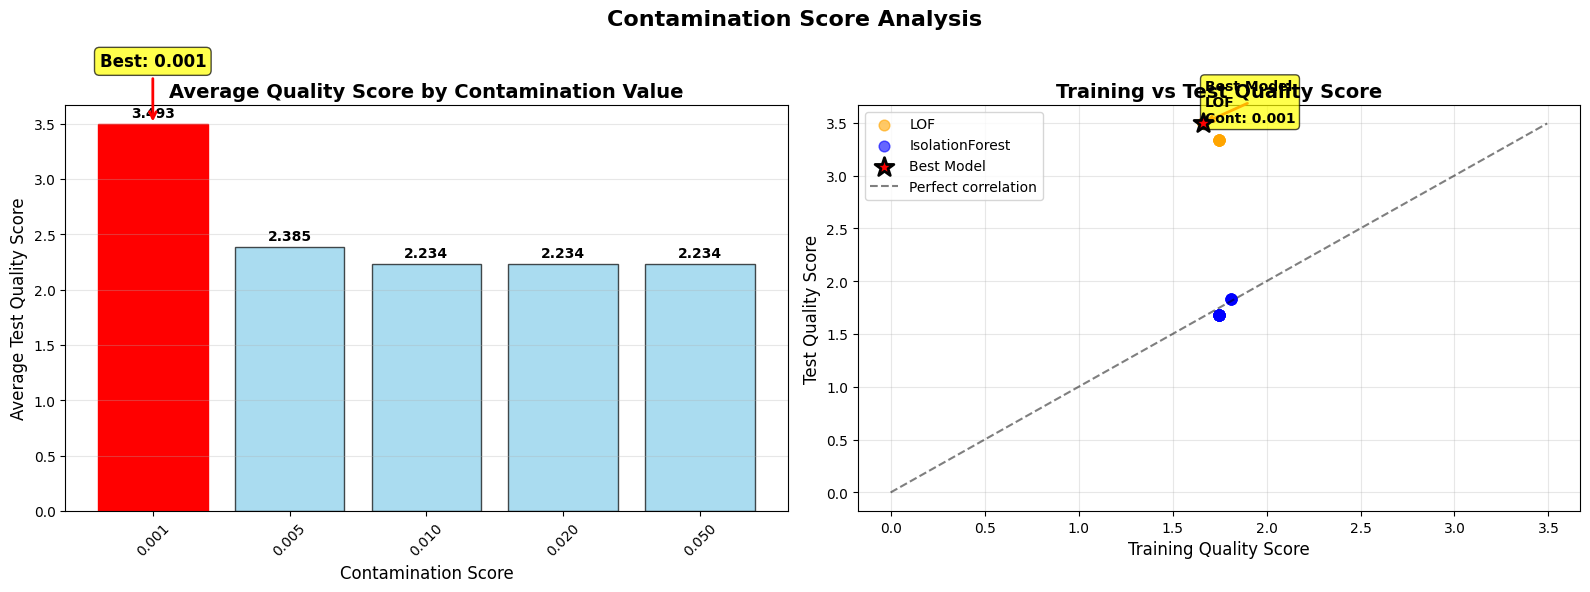


CONTAMINATION SCORE ANALYSIS SUMMARY
Best model method: LOF
Best contamination score: 0.001
Best model test quality score: 3.4930
Best model training quality score: 1.6609
Total configurations evaluated: 39
Models that detected anomalies: 39

Contamination scores tested: [0.001, 0.005, 0.01, 0.02, 0.05]
Average quality scores by contamination:
  0.001: 3.4930
  0.005: 2.3851
  0.010: 2.2336
  0.020: 2.2336
  0.050: 2.2336
Quality score range: 1.6830 - 3.4930
Anomaly count range: 1 - 7


In [224]:

#The list of contamination values tells the model what is the expected proportion of anomalies (outliers) in the dataset. 
#Each value in the list represents a different assumption about how much of the data is abnormal. 
# By testing multiple contamination levels, the model can compare how many anomalies are detected and how strongly anomalous they are.
#In other words, contamination helps the model decide what to flag as normal and what to flag as abnormal (anomaly). 

print("\nAnomaly Detection and Evaluation")
print("-" * 40)

# Combine all results and detect anomalies
all_results = isolation_results + lof_results

if all_results:
    print(f"Total trained models: {len(all_results)}")
    model_evaluations, chosen_model = detector.detect_and_print_best_model_anomalies(all_results, X_test_scaled, X_test_clean)
    
    # Create visualizations
    if model_evaluations and chosen_model:
        print("\nVisualization")
        print("-" * 40)
        detector.plot_comprehensive_contamination_analysis(model_evaluations, chosen_model)
    
else:
    print("No models were successfully trained")
        


In [62]:
!jupyter nbconvert --to html replayAttack.ipynb


[NbConvertApp] Converting notebook replayAttack.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 478637 bytes to replayAttack.html
